## Text Classification ##

In [1]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

from datasets import load_dataset

emotions = load_dataset("emotion")

emotions

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [2]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [3]:
len(train_ds)

16000

In [4]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [5]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [6]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [7]:
import pandas as pd

train_ds = train_ds.to_pandas()
train_ds.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
label_names = emotions['train'].features["label"].names

In [9]:
train_ds['label_name'] = train_ds['label'].apply(lambda x: label_names[x])

In [10]:
train_ds.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


#### Class Distribution ####

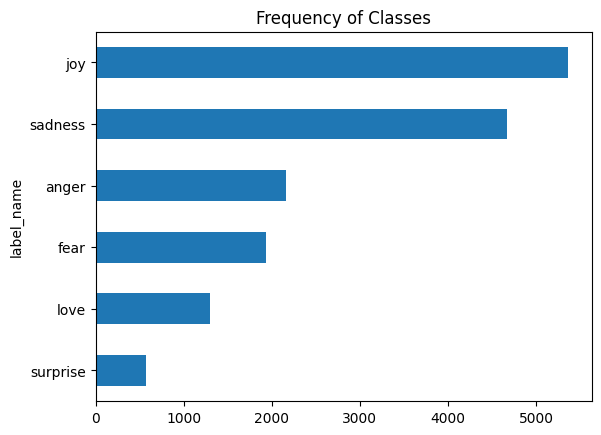

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
train_ds['label_name'].value_counts(ascending = True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

The dataset is heavily imbalanced; the `joy` and `sadness` classess appear frequently, wheras `love` and `surprise` are about 5-10 times rarer.

#### Tweet Lengths Per Emotion ####

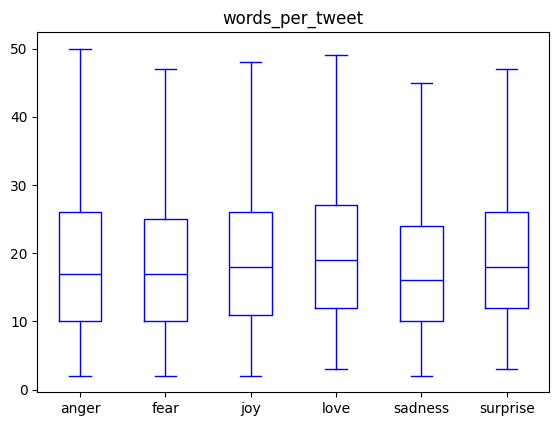

In [12]:
train_ds["words_per_tweet"] = train_ds["text"].str.split().apply(len)
train_ds.boxplot("words_per_tweet", by = "label_name", grid = False,
                 showfliers = False, color = "blue")
plt.suptitle("")
plt.xlabel("")
plt.show()

For each emotion, most tweets are around 15 words long and the longest tweets are well below **DistilBERT's** `maximum context size`. 

#### From Text to Tokens ####

Character Tokenization

In [13]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [14]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [15]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [16]:
import torch 
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes = len(token2idx))         ## tf.one_hot() in TensorFlow
one_hot_encodings.shape

torch.Size([38, 20])

In [17]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


Word Tokenization

In [18]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


Subword Tokenization 

It was a compromise between character and word tokenization that preserved all the input information and some of the input structure

In [19]:
from transformers import AutoTokenizer

model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

In [20]:
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model)

In [21]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [22]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [23]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [24]:
tokenizer.vocab_size

30522

In [25]:
tokenizer.model_max_length

512

In [26]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

#### Tokenizing the Whole Dataset ####

In [27]:
def tokenize(batch):
    return tokenizer(batch['text'], padding = True, truncation = True)

In [28]:
print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [29]:
emotions_encoded = emotions.map(tokenize, batched = True, batch_size = None)

In [30]:
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


#### Training a Text Classifier ####
##### Transformers as Feature Extractors #####

In [31]:
## Using pretrained models

from transformers import AutoModel

model = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model).to(device)

2025-05-16 13:31:36.656527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747382496.671404   20406 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747382496.676020   20406 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747382496.688721   20406 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747382496.688745   20406 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747382496.688746   20406 computation_placer.cc:177] computation placer alr

In [32]:
## Extracting the last hidden states 
text = "this is a test"
inputs = tokenizer(text, return_tensors = "pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [33]:
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)    

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [34]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [35]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [36]:
def extract_hidden_states(batch):
    ## Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    ## Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    ## Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [37]:
emotions_encoded.set_format("torch", columns = ['input_ids', 'attention_mask', 'label'])

In [38]:
import os
os.makedirs("cache", exist_ok = True)

emotions_hidden = {}
## Process each split separately
for split in ["train","validation","test"]:
    ds = emotions_encoded[split]
    ds_hidden = ds.map(
        extract_hidden_states, batched=True, batch_size=8,
        cache_file_name=f"./cache/{split}_hidden.arrow"
    )
    emotions_hidden[split] = ds_hidden
    torch.cuda.empty_cache()  # free GPU memory between splits

In [39]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [40]:
## Creating a feature matrix
import numpy as np

X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])
X_train.shape, X_valid.shape


/tmp/ipykernel_20406/2064894560.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_train = np.array(emotions_hidden['train']['hidden_state'])
/tmp/ipykernel_20406/2064894560.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_valid = np.array(emotions_hidden['validation']['hidden_state'])
/tmp/ipykernel_20406/2064894560.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_train = np.array(emotions_hidden['train']['label'])
/tmp/ipykernel_20406/2064894560.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyw

((16000, 768), (2000, 768))

In [41]:
## Visualizing the training set
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

## Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
## Initialize and fit UMAP
mapper = UMAP(n_components = 2, metric = 'cosine').fit(X_scaled)
## Create a DataFrame of 2d embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns = ['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,4.314746,3.232043,0
1,-2.987012,3.874458,0
2,5.104083,6.730587,3
3,-2.558755,5.846985,2
4,-3.510761,5.692326,3


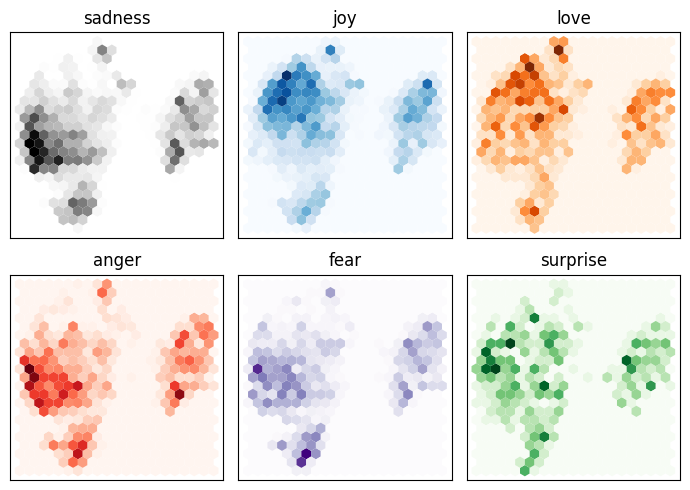

In [42]:
fig, axes = plt.subplots(2, 3, figsize = (7,5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap = cmap,
                   gridsize = 20, linewidth = (0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()    

In [43]:
## Training a simple classifier

from sklearn.linear_model import LogisticRegression
## Increase 'max_iter' to guarantee convergence
lr_clf = LogisticRegression(max_iter = 1000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.633

In [44]:
from sklearn.dummy import DummyClassifier
## Dummy Classifier with the most frequent class
dummy_clf = DummyClassifier(strategy = "most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

So, our simple classifier with DistilBERT embeddings is significantly better than our
baseline. We can further investigate the performance of the model by looking at the
confusion matrix of the classifier, which tells us the relationship between the true and
predicted labels:

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

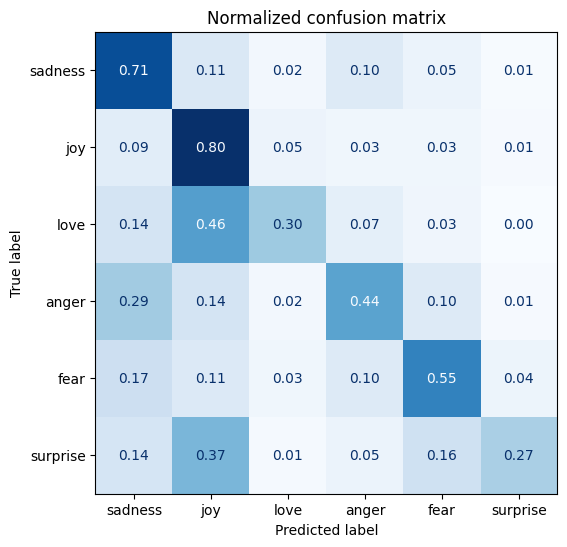

In [46]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that anger and fear are most often confused with sadness, which agrees with the observation we made when visualizing the embeddings. Also, love and surprise are frequently mistaken for joy.

#### Fine-Tuning Transformers ####

In [47]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model_ckpt = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
## Defining the performance metric

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average = 'weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [49]:
from huggingface_hub import notebook_login
notebook_login()

In [53]:
## Training the model
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(emotions['train']) // batch_size
model_name = "bert-base-uncased-finetuned-emotion"
training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  eval_strategy = "epoch",
                                  disable_tqdm = False,
                                  logging_steps = logging_steps,
                                  push_to_hub = True,
                                  log_level = "error")

In [54]:
trainer = Trainer(model = model, args = training_args,
                  compute_metrics = compute_metrics,
                  train_dataset = emotions_encoded['train'],
                  eval_dataset = emotions_encoded['validation'],
                  tokenizer = tokenizer)
trainer.train()

/tmp/ipykernel_20406/3087790740.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model = model, args = training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.413900,0.227792,0.929500,0.930253
2,0.150600,0.186061,0.939500,0.939482


TrainOutput(global_step=4000, training_loss=0.28227954864501953, metrics={'train_runtime': 568.1291, 'train_samples_per_second': 56.325, 'train_steps_per_second': 7.041, 'total_flos': 720342861696000.0, 'train_loss': 0.28227954864501953, 'epoch': 2.0})

In [55]:
preds_output = trainer.predict(emotions_encoded['validation'])

In [56]:
preds_output.metrics

{'test_loss': 0.1860613375902176,
 'test_accuracy': 0.9395,
 'test_f1': 0.9394823657121142,
 'test_runtime': 6.1235,
 'test_samples_per_second': 326.609,
 'test_steps_per_second': 40.826}

In [57]:
y_preds = np.argmax(preds_output.predictions, axis = 1)

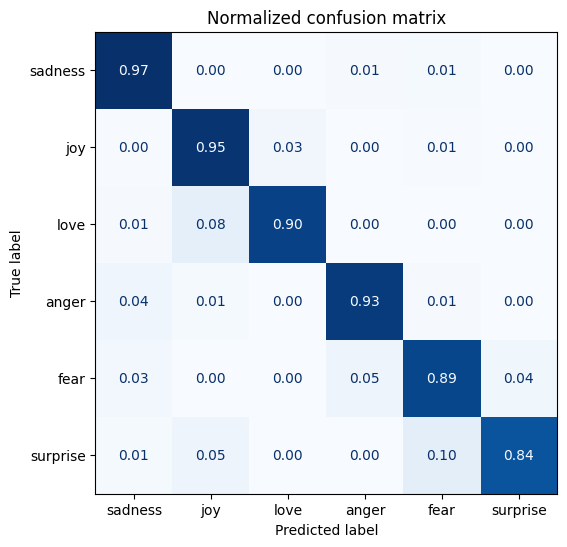

In [58]:
plot_confusion_matrix(y_preds, y_valid, labels)

This is much closer to the ideal diagonal confusion matrix. The love category is still often confused with joy, which seems natural. surprise is also frequently mistaken for joy, or confused with fear.

### Error Analysis ###

In [63]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    ## Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis = -1)
        loss = cross_entropy(output.logits, batch['label'].to(device),
                             reduction = "none")
        
    ## Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}    

In [ ]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=8)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [66]:
label_int2str = emotions_encoded["train"].features["label"].int2str

emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

In [68]:
df_test.sort_values("loss", ascending = False).head()

,text,label,predicted_label,loss
1801,i feel that he was being overshadowed by the s...,love,sadness,8.528140
1581,i feel stronger clearer but a little annoyed n...,anger,joy,8.487782
1950,i as representative of everything thats wrong ...,surprise,sadness,8.464826
882,i feel badly about reneging on my commitment t...,love,sadness,8.049677
1870,i guess i feel betrayed because i admired him ...,joy,sadness,8.033780


In [69]:
df_test.sort_values("loss", ascending = True).head(10)

,text,label,predicted_label,loss
11,i was dribbling on mums coffee table looking o...,joy,joy,0.000361
1597,i must say that i do feel better in myself and...,joy,joy,0.000363
52,i love this song and it always makes me feel h...,joy,joy,0.000368
835,i alternate between feeling perfectly happy wi...,joy,joy,0.000369
213,i didnt regret anything after bought this and ...,joy,joy,0.000372
1137,i think i may be feeling sociable,joy,joy,0.000376
1528,i am feeling a little happy with him,joy,joy,0.000377
1657,i get up to refill my coffee and feel that ple...,joy,joy,0.000377
1619,i sat in the car and read my book which suited...,joy,joy,0.000377
1017,i will be happy when someone i know from acros...,joy,joy,0.000378


In [70]:
## Saving and sharing the model
trainer.push_to_hub(commit_message = "Training Text Classifier Completed!")

events.out.tfevents.1747383112.pop-os.20406.0:   0%|          | 0.00/6.67k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/vjay98/bert-base-uncased-finetuned-emotion/commit/90bad1604414f2d6e82f4ec22039052bba61beaf', commit_message='Training Text Classifier Completed!', commit_description='', oid='90bad1604414f2d6e82f4ec22039052bba61beaf', pr_url=None, repo_url=RepoUrl('https://huggingface.co/vjay98/bert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='vjay98/bert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)

In [71]:
from transformers import pipeline
model_id = "vjay98/bert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model = model_id)

config.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [72]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores = True)

/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


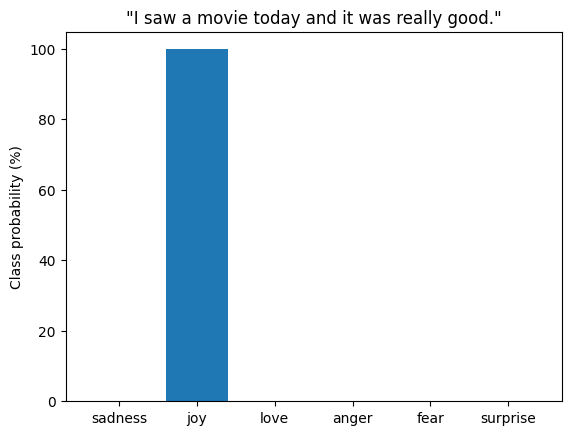

In [73]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df['score'], color = 'C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()